# Exercise 5 - Multicompartment Hodgkin & Huxley Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib import rcParams
% matplotlib inline

In [2]:
rcParams.update({'font.size': 22})

## Equations

### Constants

In [3]:
C_m = 1 #membrane capacitance, in uF/cm^2

g_Na = 120.0 #maximum conducances, in mS/cm^2
g_K  = 36.0
g_L  = 0.3

V_Na = 115 #Nernst reversal potentials, in mV
V_K  = -12
V_L  = 10.6
V_rest = -70


In [4]:
g_axon = 0.1 
r_axon = 2*10e-4
l_comp = 0.1 * 10e-4

In [5]:
Ra = g_axon * l_comp / (np.pi * r_axon**2)
Ra

0.7957747154594769

### Rate equations V in mV:
non-linear paramiters alfa and beta

In [6]:
def alpha_m(u): return (2.5 - 0.1 * u) / (np.exp(2.5 - 0.1 * u) - 1)
def alpha_n(u): return (0.1 - 0.01 * u) / (np.exp(1 - 0.1 * u ) - 1)
def alpha_h(u): return (0.07 * np.exp(-u / 20))

def beta_m(u):  return 4 * np.exp((-u) / 18)
def beta_n(u):  return 0.125 * np.exp((-u) / 80)
def beta_h(u):  return 1 / (np.exp(3 - 0.1 * u) + 1)

### Temperature correction

In [7]:
def temp_corr(T): return 3**(0.1*(T-6.3))  

### Time constants
τx(u)=[αx(u)+βx(u)] ^ −1

In [8]:
def tau_m(u): return (alpha_m(u) + beta_m(u))**(-1)
def tau_n(u): return (alpha_n(u) + beta_n(u))**(-1)
def tau_h(u): return (alpha_h(u) + beta_h(u))**(-1)

In [9]:
def m_ss(u): return alpha_m(u) / (alpha_m(u) + beta_m(u))
def n_ss(u): return alpha_n(u) / (alpha_n(u) + beta_n(u))
def h_ss(u): return alpha_h(u) / (alpha_h(u) + beta_h(u))

## Hodgkin & Huxley Neuro Model
implement a function that calculates the ionic current density i_ion, 
use the exponential-euler solver



In [10]:
def dm_du(m, u): return alpha_m(u) * (1 - m) - beta_m(u) * m
def dn_du(n, u): return alpha_n(u) * (1 - n) - beta_n(u) * n
def dh_du(h, u): return alpha_h(u) * (1 - h) - beta_h(u) * h

## Model

In [11]:
def hh_current(M, N, H, u):
    INa = g_Na * (M**3 * H) * (u - V_Na)  #sodium channel
    IK  = g_K  * (N**4    ) * (u - V_K)   #potas
    IL  = g_L               * (u - V_L)

    return INa + IK + IL

In [12]:
def hh_model_exp(temp, T, dt, I_stim):
    t = np.linspace(0, T, int(T/dt))
    M = np.zeros_like(t)
    N = np.zeros_like(t)
    H = np.zeros_like(t)
    U = np.zeros_like(t)
        
    M[0], N[0], H[0] = m_ss(0), n_ss(0), h_ss(0)
    k = temp_corr(temp)
    
    for n in range(0, len(I)-1):
        u = U[n]
        A_m = -1 * k * (alpha_m(u) + beta_m(u))
        A_n = -1 * k * (alpha_n(u) + beta_n(u))
        A_h = -1 * k * (alpha_h(u) + beta_h(u))
        B_m = k * alpha_m(u)
        B_n = k * alpha_n(u)
        B_h = k * alpha_h(u)
      
        M[n+1] = M[n] * np.exp(A_m * dt) + B_m/A_m * (np.exp(A_m * dt)-1)
        N[n+1] = N[n] * np.exp(A_n * dt) + B_n/A_n * (np.exp(A_n * dt)-1)
        H[n+1] = H[n] * np.exp(A_h * dt) + B_h/A_h * (np.exp(A_h * dt)-1)
        
        I_ion = hh_current(M[n+1], N[n+1], H[n+1], u)
        U[n+1] = U[n] - 1/C_m * (I_ion - I_stim[n]) * dt
    return U, M, N, H

## Multicompartment Model Adaptation 

### Connectivity Matrix

In [13]:
C = np.identity(100)
np.fill_diagonal(C, -2)
C[0][0] = -1
C[-1][-1] = -1

for i in range(0,100):
    for j in range(0,100):
        if i==j+1:
            C[i][j] = 1
        if i==j-1:
            C[i][j] = 1

In [14]:
def hh_model_exp_multi(num, temp, T, dt, I_stim):
    l = int(T/dt)
    M = np.zeros((num,l))
    N = np.zeros((num,l))
    H = np.zeros((num,l))
    U = np.zeros((num,l))

    M[:,0] = np.ones(num) * m_ss(0)
    N[:,0] = np.ones(num) * n_ss(0)
    H[:,0] = np.ones(num) * h_ss(0)
    k = temp_corr(temp)

    for n in range(0, num-1):
        for t in range(0, len(I)-1):
            u = U[n][t]
            A_m = -1 * k * (alpha_m(u) + beta_m(u))
            A_n = -1 * k * (alpha_n(u) + beta_n(u))
            A_h = -1 * k * (alpha_h(u) + beta_h(u))
            B_m = k * alpha_m(u)
            B_n = k * alpha_n(u)
            B_h = k * alpha_h(u)

            M[n][t+1] = M[n][t] * np.exp(A_m * dt) + B_m/A_m * (np.exp(A_m * dt)-1)
            N[n][t+1] = N[n][t] * np.exp(A_n * dt) + B_n/A_n * (np.exp(A_n * dt)-1)
            H[n][t+1] = H[n][t] * np.exp(A_h * dt) + B_h/A_h * (np.exp(A_h * dt)-1)

            I_ion = hh_current(M[n][t+1], N[n][t+1], H[t+1], u)
            print(M)

            U[n][t+1] = U[n][t] - 1/C_m * (I_ion - I_stim[n][t]) * dt + 1/(C_m * Ra) * C * U[n][t] * dt

    return U


In [15]:
def hh_model_exp_multi(num, temp, T, dt, I_stim):
    l = int(T/dt)
    M = np.zeros((num,l))
    N = np.zeros((num,l))
    H = np.zeros((num,l))
    U = np.zeros((num,l))
#     I_ion = np.zeros((num,l))

    M[:,0] = np.ones(num) * m_ss(0)
    N[:,0] = np.ones(num) * n_ss(0)
    H[:,0] = np.ones(num) * h_ss(0)
    k = temp_corr(temp)

#     for t in range(0, 100-1):
    for t in range(0, l-1):
        u = U[:,t]
        A_m = -1 * k * (alpha_m(u) + beta_m(u))
        A_n = -1 * k * (alpha_n(u) + beta_n(u))
        A_h = -1 * k * (alpha_h(u) + beta_h(u))
        B_m = k * alpha_m(u)
        B_n = k * alpha_n(u)
        B_h = k * alpha_h(u)

        M[:,t+1] = M[:,t] * np.exp(A_m * dt) + B_m/A_m * (np.exp(A_m * dt)-1)
        N[:,t+1] = N[:,t] * np.exp(A_n * dt) + B_n/A_n * (np.exp(A_n * dt)-1)
        H[:,t+1] = H[:,t] * np.exp(A_h * dt) + B_h/A_h * (np.exp(A_h * dt)-1)

#         I_ion[:][t+1] = hh_current(M[:][t+1], N[:][t+1], H[:][t+1], u)
        I_ion = hh_current(M[:,t+1], N[:,t+1], H[:,t+1], u)
        
#         U[:][t+1] = U[:][t] - 1/C_m * (I_ion - I_stim[:][t]) * dt + 1/(C_m * Ra) * C * U[:][t] * dt
#         A = 1/C_m * (I_ion - I_stim[:,t]) * dt
#         Bp = 1/(C_m * Ra) * np.dot(C,U[:,t]) * dt
    
#         U[:,t+1] = U[:,t] - A + Bp        
        U[:,t+1] = U[:,t] - 1/C_m * (I_ion - I_stim[:,t]) * dt + 1/(C_m * Ra) * np.dot(C, U[:,t]) * dt
# 
    return U



In [23]:
T = 100
dt = 0.01
N = 100
l = int(T/dt)

I = np.zeros((N, l))
I[:,10] = np.ones((N))
print()

V = hh_model_exp_multi(N, 6.3, T, dt, I)
np.shape(V)

(100, 10000)

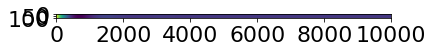

In [25]:
plt.imshow(V)

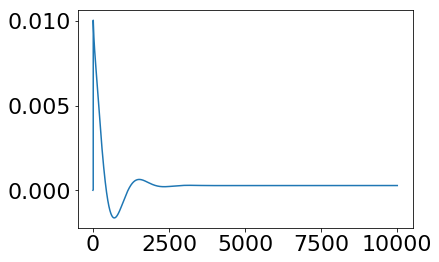

In [26]:
t1 = np.linspace(0, len(V[1,:]), len(V[1,:]))
plt.plot(t1, V[1,:], label='membrane potential');

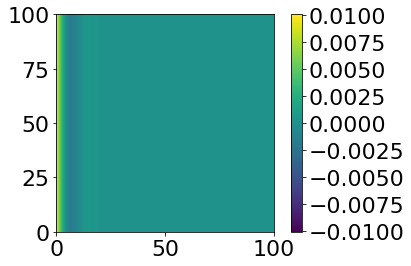

In [24]:
plt.imshow(V,
           interpolation='bilinear',
           extent=[0, 100, 0, 100],
           origin='lower',
           vmax=abs(V).max(),
           vmin=-abs(V).max())
plt.colorbar()
plt.show()

# cbar = plt.colorbar()
# cbar.set_label('Voltage V [mV]')